In [15]:
import os
import shutil
import requests
import zipfile
from time import strftime

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Layer, Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, FalseNegatives, FalsePositives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model
from tensorflow.random import normal

import matplotlib.pyplot as plt
import heapq


DATA PROCESSING

In [16]:
# BASE_PATH = os.path.dirname(__file__)
BASE_PATH = os.getcwd()

config = {
    "data_folder": os.path.join(BASE_PATH, "data"),
    "POS_PATH": os.path.join(BASE_PATH, 'data' , 'positive'),
    "NEG_PATH": os.path.join(BASE_PATH, 'data', 'negative'),
    "ANC_PATH": os.path.join(BASE_PATH, 'data', 'anchor'),
    "VAL_PATH": os.path.join(BASE_PATH, 'data', 'validation'),


    "dataset_url": "https://www.kaggle.com/api/v1/datasets/download/jessicali9530/lfw-dataset",
    "save_model_folder": os.path.join(BASE_PATH, "saved_models"),


    "IM_SIZE": 100,
    "LEARNING_RATE": 0.01,
    "EPOCHS": 5,
    "BATCH_SIZE": 32,
    "TRAINING_RATIO": 0.8,
    "VALIDATION_RATIO": 0.1,
    "TESTING_RATIO": 0.1,
    "GENERATOR_ITER": 80,
}

In [17]:
def download_data(dataset_url, target_dir):
    os.makedirs(target_dir, exist_ok=True)

    zip_path = os.path.join(target_dir, "data.zip")

    path = os.path.join(target_dir, 'lfw')
    path_image_dirs = os.path.join(target_dir, 'lfw/lfw-deepfunneled/lfw-deepfunneled/')

    if os.path.exists(path):
        print("Data exist...")
        return

    print("Downloading Dataset...")

    response = requests.get(dataset_url, stream=True)
    if response.status_code == 200:
        with open(zip_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)

        # Extract the ZIP file
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(path)

        # Remove the ZIP file after extraction
        os.remove(zip_path)

        print(f"Data downloaded and extracted to '{target_dir}'")
    else:
        print("Failed to download the file")

    POS_PATH = config["POS_PATH"]
    NEG_PATH = config["NEG_PATH"]
    ANC_PATH = config["ANC_PATH"]
    VAL_PATH = config["VAL_PATH"]

    if not os.path.exists(POS_PATH):
        os.makedirs(POS_PATH)
    if not os.path.exists(NEG_PATH):
        os.makedirs(NEG_PATH)
    if not os.path.exists(ANC_PATH):
        os.makedirs(ANC_PATH)
    if not os.path.exists(VAL_PATH):
        os.makedirs(VAL_PATH)

    for directory in os.listdir(path_image_dirs):
        for file in os.listdir(os.path.join(path_image_dirs, directory)):
            EX_PATH = os.path.join(path_image_dirs, directory, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

    try:
        shutil.rmtree(path)
        print(f"Directory '{path}' and its contents removed successfully.")
    except FileNotFoundError:
        print(f"Directory '{path}' not found.")
    except OSError as e:
        print(f"Error: {e}")
    print("Download data done!!")

In [18]:
def preprocess(file_path):
    IM_SIZE = config["IM_SIZE"]
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (IM_SIZE,IM_SIZE))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Add a channel dimension if it's missing
    # img = tf.expand_dims(img, axis=0)

    # Return image
    return img

def preprocess_twin(input_img, validation_img, label):
    label = tf.cast(label, tf.float32)
    return ((preprocess(input_img), preprocess(validation_img)), label)

In [19]:
def load_data(raw_data):
    BATCH_SIZE = config["BATCH_SIZE"]
    TRAINING_RATIO = config["TRAINING_RATIO"]
    VALIDATION_RATIO = config["VALIDATION_RATIO"]
    TESTING_RATIO = config["TESTING_RATIO"]

    DATA_SIZE = raw_data.cardinality().numpy()

    TRAINING_SIZE = round(DATA_SIZE*TRAINING_RATIO)
    VALIDATION_SIZE = round(DATA_SIZE*VALIDATION_RATIO)
    TESTING_SIZE = round(DATA_SIZE*TESTING_RATIO)

    data = raw_data.map(preprocess_twin)
    data = data.cache()
    data = data.shuffle(buffer_size=10000)

    # Training partition
    train_data = data.take(TRAINING_SIZE)
    train_data = train_data.batch(BATCH_SIZE)
    train_data = train_data.prefetch(8)

    # Validation partition
    validation_data = data.skip(TRAINING_SIZE)
    validation_data = validation_data.take(VALIDATION_SIZE)
    validation_data = validation_data.batch(BATCH_SIZE)
    validation_data = validation_data.prefetch(8)

    # Testing partition
    test_data = data.skip(TRAINING_SIZE + VALIDATION_SIZE)
    test_data = test_data.take(VALIDATION_SIZE)
    test_data = test_data.batch(BATCH_SIZE)
    test_data = test_data.prefetch(8)

    return train_data, validation_data, test_data

In [20]:
def load_data_generator():
    """
    Data = [
        (filename1, filename2, 1 or 0),
        (filename1, filename2, 1 or 0),
        ...
    ]
    """
    POS_PATH = config["POS_PATH"]
    NEG_PATH = config["NEG_PATH"]
    ANC_PATH = config["ANC_PATH"]

    POS_PATH_child_dir = None
    ANC_PATH_child_dir = None

    Data = None             # main data that will return

    try:
        POS_PATH_child_dir = os.listdir(POS_PATH)
        ANC_PATH_child_dir = os.listdir(ANC_PATH)
        for p in POS_PATH_child_dir:
            if p.startswith("."):
                POS_PATH_child_dir.remove(p)
        for p in ANC_PATH_child_dir:
            if p.startswith("."):
                ANC_PATH_child_dir.remove(p)
    except OSError as e:
        print(f"An error occurred: {e}")

    # negative raw data
    NEG_PATH_P = os.path.join(NEG_PATH, "")
    negative = tf.data.Dataset.list_files(NEG_PATH_P + '*.jpg')
    negative_size = negative.cardinality().numpy()

    archor_positive = []

    for p in POS_PATH_child_dir:
        POS_PATH_P = os.path.join(POS_PATH, p, "")
        ANC_PATH_P = os.path.join(ANC_PATH, p, "")

        anchor = tf.data.Dataset.list_files(ANC_PATH_P + '*.jpg')
        positive = tf.data.Dataset.list_files(POS_PATH_P + '*.jpg')

        archor_positive.append((anchor, positive))

    for _ in range(config["GENERATOR_ITER"]):
        Data = None

        for anchor, positive in archor_positive:
            try:
                anchor = anchor.shuffle(buffer_size=10000)
                positive = positive.shuffle(buffer_size=10000)

                anchor_size = anchor.cardinality().numpy()
                positive_size = positive.cardinality().numpy()

                shuffled_negative = negative.shuffle(buffer_size=10000).take(anchor_size)

                positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(anchor_size))))
                shuffled_negative = tf.data.Dataset.zip((anchor, shuffled_negative, tf.data.Dataset.from_tensor_slices(tf.zeros(anchor_size))))

                if Data is None:
                    Data = positives.concatenate(shuffled_negative)
                else:
                    positives = positives.concatenate(shuffled_negative)
                    Data = positives.concatenate(shuffled_negative)
            except GeneratorExit:
                return
            except Exception as e:
                print(f"Error processing class {p}: {e}")
                continue

        yield load_data(Data)

In [21]:
download_data(config["dataset_url"], config["data_folder"])

Data downloaded and extracted to '/content/data'
Directory '/content/data/lfw' and its contents removed successfully.
Download data done!!


MODEL

In [22]:
IM_SIZE = config["IM_SIZE"]

class EmbeddingModel(Model):
    def __init__(self, **kwargs):
        super(EmbeddingModel, self).__init__(name='embedding', **kwargs)

        # First block
        self.conv1 = Conv2D(64, (10, 10), activation='relu')
        self.pool1 = MaxPooling2D((2, 2), padding='same')

        # Second block
        self.conv2 = Conv2D(128, (7, 7), activation='relu')
        self.pool2 = MaxPooling2D((2, 2), padding='same')

        # Third block
        self.conv3 = Conv2D(128, (4, 4), activation='relu')
        self.pool3 = MaxPooling2D((2, 2), padding='same')

        # Final embedding block
        self.conv4 = Conv2D(256, (4, 4), activation='relu')
        self.flatten = Flatten()
        self.dense = Dense(4096, activation='sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.flatten(x)
        x = self.dense(x)

        return x


# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self):
        super(L1Dist, self).__init__(name='distance')

    def call(self, anchor_embedding, validation_embedding):
        return tf.math.abs(anchor_embedding - validation_embedding)

@register_keras_serializable()
class SiameseModel(Model):
    def __init__(self, **kwargs):
        super(SiameseModel, self).__init__(**kwargs)

        self.embedding = EmbeddingModel()

        self.l1_distance = L1Dist()

        self.classifier = Dense(1, activation='sigmoid')

    def call(self, inputs):
        input_image, validation_image = inputs[0], inputs[1]

        # input_a = Input(shape=(IM_SIZE, IM_SIZE, 3))
        # input_b = Input(shape=(IM_SIZE, IM_SIZE, 3))
        # Get embeddings
        input_embedding = self.embedding(input_image)
        validation_embedding = self.embedding(validation_image)

        # Calculate distance
        distance = self.l1_distance(input_embedding, validation_embedding)

        # Classification
        output = self.classifier(distance)

        return output

    def get_embedding_vector(self, img_name_list):
        output = []

        embedding = None

        for name, img in img_name_list:
            img = tf.expand_dims(img, axis=0)
            embedding_vec = self.embedding(img)

            output.append((name, embedding_vec))

        return output

    def custom_prediction(self, input_img, val_img_embedding):
        input_img = tf.expand_dims(input_img, axis=0)
        person = self.embedding(input_img)

        pq = []
        """
        val_img_embedding = [
            ("Ankit kumar", [33, 4, 4, 534 ...]),
            ("Anup kumar", [33, 4, 4, 534 ...]),
            ("Ankit kumar", [33, 4, 4, 534 ...]),
        ]
        """
        for name, val_emb in val_img_embedding:
            dist = self.l1_distance(person, val_emb)
            output = self.classifier(dist)

            output =  output.numpy().item()

            if len(pq) < 3:
                heapq.heappush(pq, (output, name))
            else:
                p, n = heapq.heappop(pq)
                if output > p:
                    heapq.heappush(pq, (output, name))
                else:
                    heapq.heappush(pq, (p, n))

        value = []
        while pq:
            value.append(heapq.heappop(pq))

        value.reverse()

        return value

custom_objects = {'SiameseModel': SiameseModel, 'EmbeddingModel': EmbeddingModel, 'L1Dist': L1Dist}

In [23]:
model = SiameseModel()
dummy_input = tf.random.normal((1, config["IM_SIZE"], config["IM_SIZE"], 3))
model((dummy_input, dummy_input))  # triggers model build
model.summary()

Model: "siamese_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (EmbeddingModel)           │ ?                           │      38,960,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ distance (L1Dist)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 1)                      │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

training

In [24]:
def training(saved_model_path=None):
    model = None

    # checkpoint_callback = ModelCheckpoint(
    #     'best_weights.keras',
    #     monitor = 'val_precision',
    #     mode='max',
    #     verbose=1,
    #     save_best_only = True
    # )

    if saved_model_path:
        print("Loading saved model")

        # Load the model with custom_objects
        model = load_model(saved_model_path, custom_objects=custom_objects)
    else:
        model = SiameseModel()
        dummy_input = normal((1, config["IM_SIZE"], config["IM_SIZE"], 3))
        model((dummy_input, dummy_input))  # triggers model build

        loss_function = BinaryCrossentropy()
        metrics = [BinaryAccuracy(name="accuracy"), Precision(name="precision")]

        model.compile(
            optimizer = Adam(learning_rate = config["LEARNING_RATE"]),
            loss = loss_function,
            metrics = metrics,
        )

    model.summary()

    data_gen = load_data_generator()
    combined_history = {}


    for train_data, validation_data, test_data in data_gen:

        history = model.fit(
            train_data,
            validation_data = validation_data,
            epochs = config["EPOCHS"],
            verbose = 1
        )

        for key, values in history.history.items():
            if key not in combined_history:
                combined_history[key] = []
            combined_history[key].extend(values)

        evaluation_metrics = model.evaluate(test_data)
        print("Test Evaluation:", dict(zip(model.metrics_names, evaluation_metrics)))

    if saved_model_path:
        model.save(saved_model_path)
    else:
        path = os.path.join(config["save_model_folder"], f'model-{strftime("%Y%m%d-%H%M%S")}.keras')
        model.save(path)

    return combined_history

In [25]:
history = training()

Model: "siamese_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (EmbeddingModel)           │ ?                           │      38,960,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ distance (L1Dist)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 1)                      │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7016 - loss: 0.6527 - precision: 0.5625 - val_accuracy: 0.9000 - val_loss: 0.1783 - val_precision: 0.0000e+00
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7109 - loss: 0.4908 - precision: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 3.2396 - val_precision: 0.0000e+00
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6914 - loss: 2.6451 - precision: 0.0000e+00 - val_accuracy: 0.7000 - val_loss: 0.9685 - val_precision: 0.0000e+00
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6789 - loss: 1.6348 - precision: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.1375 - val_precision: 0.0000e+00
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7336 - loss: 0.4205 - precision: 0.7375 - val_accuracy: 0.9000 - val_loss: 0.5825 - val_precision: 0.7500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8000 - loss: 0.5303 - precision: 0.7500
Test Evaluation: {'loss': 0.5303264260292

In [30]:
path = os.path.join(config["save_model_folder"], "model-20250312-213558.keras")
history_list = training(path)

Loading saved model


Model: "siamese_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (EmbeddingModel)           │ ?                           │      38,960,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ distance (L1Dist)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (1, 1)                      │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,893,637 (445.91 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 77,929,092 (297.28 MB)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8656 - loss: 0.2934 - precision: 0.7480 - val_accuracy: 0.9000 - val_loss: 0.1727 - val_precision: 0.7500
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9016 - loss: 0.2691 - precision: 0.9452 - val_accuracy: 1.0000 - val_loss: 0.0614 - val_precision: 1.0000
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9555 - loss: 0.2083 - precision: 0.9762 - val_accuracy: 1.0000 - val_loss: 0.0450 - val_precision: 1.0000
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9539 - loss: 0.1908 - precision: 0.9490 - val_accuracy: 0.8000 - val_loss: 0.2839 - val_precision: 0.3333
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9477 - loss: 0.1287 - precision: 0.8888 - val_accuracy: 0.9000 - val_loss: 0.1498 - val_precision: 0.6667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0580 - precision: 1.0000
Test Evaluation: {'loss': 0.05799229070544243, 'compile_metrics': 1.0}

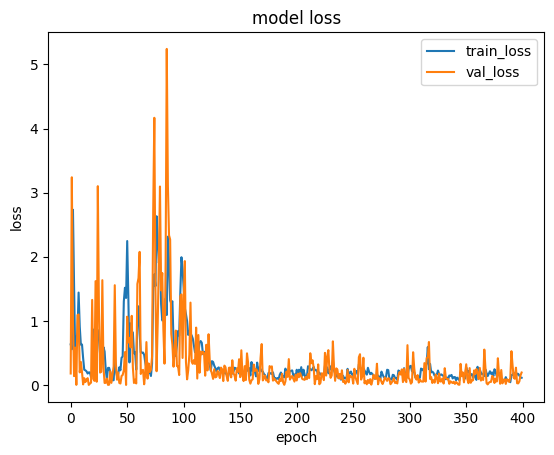

In [31]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

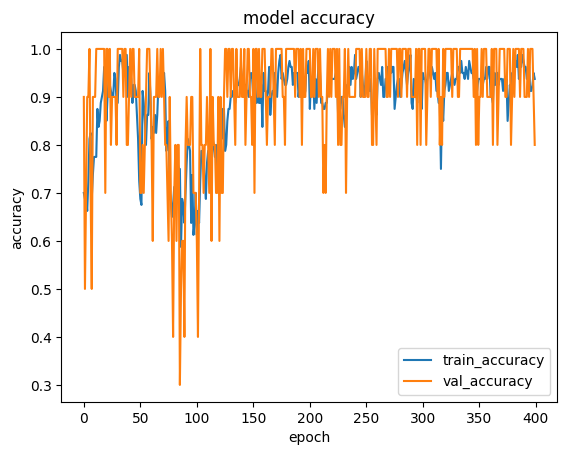

In [32]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()